#  **Urdu Handwritten Alphabets Classifier**


**MODEL 1** **INCEPTION VERSION 3**


In [ ]:
#Making a directory and fetching data form kaggle through API

In [ ]:
!mkdir -p ~/.kaggle

In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
#URDU ALBHABETS DATASET BY HAZRAT ALI (https://www.kaggle.com/datasets/hazrat/uhat-urdu-handwritten-text-dataset)
! kaggle datasets download -d hazrat/uhat-urdu-handwritten-text-dataset

In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/uhat-urdu-handwritten-text-dataset.zip' , 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.datasets import load_files
from keras.utils import np_utils
from tensorflow.keras.utils import img_to_array, load_img, array_to_img
from tensorflow.keras.layers import Dense,Flatten ,Dropout, BatchNormalization,Rescaling


In [ ]:
# Making data_paths
data_path = '/content/data/data'
train_path = '/content/data/data/characters_train_set'
test_path = '/content/data/data/characters_test_set'

In [ ]:
batch_size = 32
img_width =224
img_height =224
input_shape = (224,224,3)

In [ ]:
# Dividing the data in training and validation sets
train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
                  train_path,
                  validation_split = 0.1,
                  subset="both",
                  seed=42,
                  image_size=(img_height, img_width),
                  batch_size=batch_size
)


In [ ]:
# Checking the classes in the datasets, total 40 classes are in the dataset
class_names = train_ds.class_names
print(class_names)

In [ ]:
#Assigning indices to classes
idx_to_classes = {idx: class_name for idx, class_name in enumerate(train_ds.class_names)}
print(idx_to_classes)

In [ ]:
#let us show the different urdu alphabets
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(18):
    ax = plt.subplot(3, 6, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

In [ ]:
train_samples_per_batch = print('train_samples_per_batch =', len(train_ds))
testing_samples_per_batch = print('testing_samples_per_batch =', len(val_ds))

In [ ]:
# class_indices have the numeric tag for each balls
import pickle
TrainClasses=idx_to_classes

# Storing the face and the numeric tag for future reference
ResultMap={}
for word, wordValue in zip(idx_to_classes.values(),idx_to_classes.keys()):
    ResultMap[wordValue]=word

# Saving the face map for future reference

with open(R"E:\Data Sets\Balls Classification\ResultsMap.pkl", 'wb') as f:
    pickle.dump(ResultMap, f, pickle.HIGHEST_PROTOCOL)

print("Mapping of Face and its ID",ResultMap)

# The number of neurons for the output layer is equal to the number of faces
OutputNeurons=len(ResultMap)
print('\n The Number of output neurons: ', OutputNeurons)

Mapping of Face and its ID {0: 'alif', 1: 'alif mad aa', 2: 'ayn', 3: 'baa', 4: 'bari yaa', 5: 'cheey', 6: 'choti yaa', 7: 'daal', 8: 'dhaal', 9: 'faa', 10: 'gaaf', 11: 'ghain', 12: 'haa1', 13: 'haa2', 14: 'haa3', 15: 'hamza', 16: 'jeem', 17: 'kaaf', 18: 'khaa', 19: 'laam', 20: 'meem', 21: 'noon', 22: 'noonghunna', 23: 'paa', 24: 'qaaf', 25: 'raa', 26: 'rhraa', 27: 'seen', 28: 'seey', 29: 'sheen', 30: 'swaad', 31: 'taa', 32: 'ttaa', 33: 'twa', 34: 'waw', 35: 'zaaa', 36: 'zaal', 37: 'zhaa', 38: 'zwaa', 39: 'zwaad'}

 The Number of output neurons:  40


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

model_filepath = '/content/drive/MyDrive/Colab Notebooks/call_backs'
checkpoint = ModelCheckpoint(
    filepath = model_filepath,
    monitor = 'val_accuracy',
    mode = 'max',
    save_best_only = True,
    verbose = 1
)

In [ ]:
from keras.applications.inception_v3 import InceptionV3
from keras.models import Model
from keras.optimizers import Adam

In [ ]:
%%time
model_inceptV3= InceptionV3(weights = "imagenet", include_top=False, input_shape = (224,224, 3))


In [ ]:
model_inceptV3.summary()

In [ ]:
for layer in model_inceptV3.layers:
    layer.trainable = False

In [ ]:
model_inceptV3.summary()

In [ ]:
#freezing the extractor and saving last layer
last_layer_inceptV3= model_inceptV3.get_layer('mixed10') #Saving the last layer of the network

last_layer_output = last_layer_inceptV3.output #Saving the output of the last layer to be the input of the next layer

x = Flatten()(last_layer_output) #Flattenning the classifier input, which is the output of the last layer of the inception model
x = Rescaling(1./255)(x)
x = Dense(50, activation='relu', name='FC_2')(x) #Adding 1 dense layer of 64 neurons
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(40, activation='softmax', name='classifer')(x) # our dataset is 40 class dataset, putting 40 softmax neuron to it


model_inceptV3 = Model(inputs=model_inceptV3.input, outputs=x) #Instantiating a new_model


In [ ]:
model_inceptV3.summary()

In [ ]:
model_inceptV3.compile(loss='sparse_categorical_crossentropy', optimizer='adam',
              metrics=['accuracy'])

In [ ]:
%%time
#Training the model
history_inceptV3 = model_inceptV3.fit(train_ds, batch_size=batch_size, steps_per_epoch=len(train_ds), epochs=10,
                    verbose=0, validation_data=val_ds , callbacks =[checkpoint])

**EVALUATING INCEPTION V3 PERFORMANCE**

In [ ]:
#Plotting the learning curves for train and test accuracy
plt.plot(history_inceptV3.history['accuracy'], label='Train')
plt.plot(history_inceptV3.history['val_accuracy'], label='Validation')
plt.legend()
plt.show()

In [ ]:
#Plotting the learning curves for train and test loss
plt.plot(history_inceptV3.history['loss'], label='Train')
plt.plot(history_inceptV3.history['val_loss'], label='Validation')
plt.legend()
plt.show()

In [ ]:
model_inceptV3.metrics_names

['loss', 'accuracy']

In [ ]:
#Let us print the loss function value and overall accuracy of our model on train as well as test data.
train_loss, train_accuracy = model_inceptV3.evaluate(train_ds)
val_loss, val_accuracy = model_inceptV3.evaluate(val_ds)
print(f'Train loss is {train_loss:0.3} and train accuracy is {train_accuracy:0.1%}')
print(f'validation loss is {val_loss:0.3} and validation accuracy is {val_accuracy:0.1%}')

**MAKING INDIVIDUAL PREDICTIONS ON INCEPTIONV3**

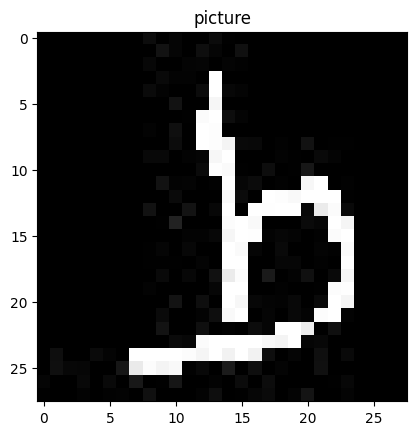

########################################
Our Models InceptionV3 Prediction is:  twa


In [ ]:
'''########################## Making single predictions ############################'''

testImage='/content/data/data/characters_test_set/Twaa/twaa (107).jpg'
test_image=load_img(testImage,target_size=(224, 224))
test_image=img_to_array(test_image)
test_image=np.expand_dims(test_image,axis=0)
result=model_inceptV3.predict(test_image,verbose=0)

img = cv2.imread(testImage)
# gray = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

plt.imshow(img)
plt.title('picture')
plt.show()

print('####'*10)
print('Our Models InceptionV3 Prediction is: ', ResultMap[np.argmax(result)])

# **Model 2 DenseNet121**

In [ ]:
from keras.applications import DenseNet121

In [ ]:
%%time
 model_Dens= DenseNet121(weights = "imagenet", include_top=False, input_shape = (224,224, 3))

In [ ]:
for layer in model_Dens.layers:
    layer.trainable = False

In [ ]:
model_Dens.summary()

In [ ]:
#freezing the extractor and saving last layer
last_layer_Dens = model_Dens.get_layer('relu') #Saving the last layer of the network

last_layer_output = last_layer_Dens.output #Saving the output of the last layer to be the input of the next layer

x = Flatten()(last_layer_output) #Flattenning the classifier input, which is the output of the last layer of the DensNet121
x = Rescaling(1./255)(x) #adding rescaling layer
x = Dense(50, activation='relu', name='FC_2')(x) #Adding 1 dense layer of 64 neurons
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(40, activation='softmax', name='classifer')(x) #Adding our new softmax layer with two hidden units

model_Dens = Model(inputs=model_Dens.input, outputs=x) #Instantiating a new_model


In [ ]:
model_Dens.summary()

In [ ]:
model_Dens.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
%%time
history_Dens = model_Dens.fit(train_ds, epochs= 3, verbose = 0, validation_data=val_ds,steps_per_epoch=len(train_ds), callbacks =[checkpoint])

**EVALUATING DENSNET121 PERFORMANCE**


In [ ]:
#Plotting the learning curves for train and test accuracy
plt.plot(history_Dens.history['accuracy'], label='Train')
plt.plot(history_Dens.history['val_accuracy'], label='Validation')
plt.legend()
plt.show()

In [ ]:
#Plotting the learning curves for train and test loss
plt.plot(history_Dens.history['loss'], label='Train')
plt.plot(history_Dens.history['val_loss'], label='Validation')
plt.legend()
plt.show()

In [ ]:
model_Dens.metrics_names

In [ ]:
#Let us print the loss function value and overall accuracy of our model on train as well as test data.
train_loss, train_accuracy = model_Dens.evaluate(train_ds)
val_loss, val_accuracy = model_Dens.evaluate(val_ds)
print(f'Train loss is {train_loss:0.3} and train accuracy is {train_accuracy:0.1%}')
print(f'validation loss is {val_loss:0.3} and validaiton accuracy is {val_accuracy:0.1%}')

**MAKING INDIVIDUAL PREDICTIONS ON DENSNET121**

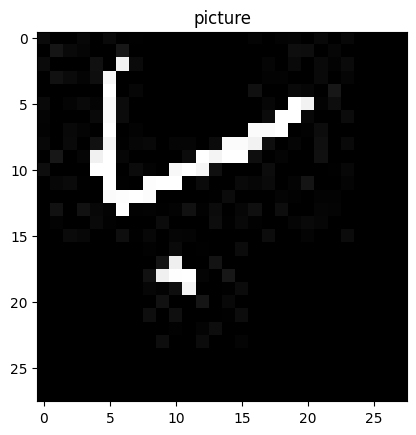

########################################
Our Models DenseNet121 Prediction is:  paa


In [ ]:
'''########################## Making single predictions ############################'''

testImage='/content/data/data/characters_test_set/baa/baa (118).jpg'
test_image=load_img(testImage,target_size=(224, 224))
test_image=img_to_array(test_image)
test_image=np.expand_dims(test_image,axis=0)
result=model_inceptV3.predict(test_image,verbose=0)

img = cv2.imread(testImage)
# gray = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

plt.imshow(img)
plt.title('picture')
plt.show()

print('####'*10)
print('Our Models DenseNet121 Prediction is: ', ResultMap[np.argmax(result)])

**END**